In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import Windower
from pyha.cores.util import *
from scipy.fftpack import fft, fftshift
plt.rcParams['figure.figsize'] = 15, 5

In [4]:
def make_fft(window):
    A = fft(window, len(window) * 8) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    return freq, response

input_signal = [1.0 + 1.0j] * 512 # this input signal basically just returns the window taps
fft_size = 256
input_signal = np.reshape(input_signal, (-1, fft_size))

## Boxcar (no window)

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = Windower(fft_size, window='boxcar', coefficient_bits=9)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 512/512 [00:00<00:00, 13382.96it/s]

INFO:sim:Flushing the pipeline... have 510 valid samples, need 512
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Simulations completed!


TypeError: object of type 'numpy.complex128' has no len()

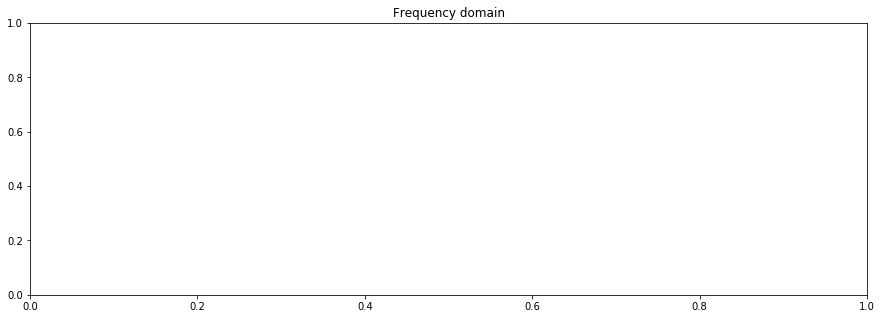

In [6]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

## Hanning

In [ ]:
# NBVAL_IGNORE_OUTPUT
dut = Windower(fft_size, window='hanning', coefficient_bits=8)
sims = simulate(dut, input_signal, simulations=simulations)

In [ ]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

## Hamming

In [ ]:
# NBVAL_IGNORE_OUTPUT
dut = Windower(fft_size, window='hamming', coefficient_bits=8)
sims = simulate(dut, input_signal, simulations=simulations)

In [ ]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.plot(*make_fft(value[0]))

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

## Coefficients are stored in LUTs (as constants)
Storing 18bit coefficnets for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~8, then synthsis tool can compress most of them.

# Synthesis

In [11]:
# NBVAL_SKIP
output_dir = '~/Documents/pyha_output'
dut = Windower(fft_size, window='hamming', coefficient_bits=9)
sims = simulate(dut, input_signal, simulations=['MODEL', 'PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

assert hardware_sims_equal(sims)
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 512/512 [00:00<00:00, 3357.80it/s]

INFO:sim:Flushing the pipeline... have 510 valid samples, need 512
INFO:sim:Flushing took 2 cycles
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DownCounter to VHDL ...


INFO:conversion:Windower to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:Windower to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Wed Sep  5 11:29:37 2018
INFO:sim:Quartus Prime Version : 18.0.0 Build 614 04/24/2018 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 257
INFO:sim:    Total combinational functions : 203
INFO:sim:    Dedicated logic registers : 106
INFO:sim:Total registers : 106
INFO:sim:Total pins : 76
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 4
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO

AssertionError: 